### 1. Environment Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import scikit_posthocs as sp

### 2. Load Data, Merged and Overview

In [5]:
# Load
df_aptitude = pd.read_csv('student_aptitude_data.csv')
df_performance = pd.read_csv('student_performance_data.csv')

# Overview1
print("Overview Columns")
df_aptitude.info()
df_performance.info()

Overview Columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   student_id      150 non-null    int64 
 1   course_level    150 non-null    object
 2   aptitude_score  150 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   student_id         150 non-null    int64  
 1   course_level       150 non-null    object 
 2   performance_score  150 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ KB


In [6]:
# Merged Data
df_merged = pd.merge(
    df_aptitude,
    df_performance,
    on=['student_id', 'course_level'],
    how='outer'
)

# Overview2
df_merged.head()

,student_id,course_level,aptitude_score,performance_score
0,1,Advanced,72,3.70
1,2,Advanced,90,3.65
2,3,Advanced,68,3.55
3,4,Advanced,84,3.45
4,5,Advanced,72,3.55


### 3. Descriptive Statistic

In [7]:
print("--- Descriptive Statistics for All Columns (Excluding student_id) ---")
display(df_merged.drop(columns=['student_id']).describe())

print("\n--- Performance Score Stats by Course Level ---")
perf_stats = df_merged.groupby("course_level", observed=False)["performance_score"].describe()
display(perf_stats)

print("\n--- Aptitude Score Stats by Course Level ---")
apt_stats = df_merged.groupby("course_level", observed=False)["aptitude_score"].describe()
display(apt_stats)


--- Descriptive Statistics for All Columns (Excluding student_id) ---


,aptitude_score,performance_score
count,150.000000,150.000000
mean,44.240000,2.540667
std,24.228133,0.652830
min,9.000000,1.550000
25%,22.000000,1.950000
50%,38.000000,2.475000
75%,65.000000,3.037500
max,97.000000,3.800000



--- Performance Score Stats by Course Level ---


,count,mean,std,min,25%,50%,75%,max
course_level,,,,,,,,
Advanced,50.0,3.239,0.384029,2.50,2.95,3.375,3.5500,3.80
Foundation,50.0,1.865,0.176777,1.55,1.75,1.825,1.9500,2.45
Intermediate,50.0,2.518,0.391460,1.90,2.25,2.475,2.7875,3.55



--- Aptitude Score Stats by Course Level ---


,count,mean,std,min,25%,50%,75%,max
course_level,,,,,,,,
Advanced,50.0,67.46,19.171844,30.0,50.00,70.0,83.0,97.0
Foundation,50.0,22.52,7.028339,9.0,17.25,21.0,26.0,41.0
Intermediate,50.0,42.74,18.279921,14.0,31.00,41.5,53.5,90.0


### 4. Statitical Testing

In [8]:
# 1. Tentukan variabel yang akan diuji
target_columns = ["performance_score", "aptitude_score"]
levels = df_merged["course_level"].unique()

for col in target_columns:
    print(f"=== Analisis Asumsi untuk: {col} ===")
    
    # --- A. UJI NORMALITAS (Shapiro-Wilk) ---
    # Kita cek normalitas per grup karena ANOVA berasumsi setiap grup berdistribusi normal
    print("1. Shapiro-Wilk Test (Normalitas per Level):")
    for level in levels:
        sample = df_merged[df_merged["course_level"] == level][col]
        stat, p = shapiro(sample)
        status = "Normal" if p > 0.05 else "Tidak Normal"
        print(f"   - {level:12}: p-value={p:.4f} ({status})")
    
    # --- B. UJI HOMOGENITAS (Levene's Test) ---
    # Mengumpulkan data per grup ke dalam list untuk di-unpack (*) ke fungsi levene
    # Ini jauh lebih ringkas daripada membuat variabel manual (adv, intm, found)
    groups = [df_merged[df_merged["course_level"] == level][col] for level in levels]
    stat_lev, p_lev = levene(*groups)
    
    status_lev = "Homogen" if p_lev > 0.05 else "Tidak Homogen (Heteroskedastis)"
    print(f"\n2. Levene’s Test (Homogenitas Varians):")
    print(f"   - p-value={p_lev:.4f} ({status_lev})")
    print("-" * 40 + "\n")

=== Analisis Asumsi untuk: performance_score ===
1. Shapiro-Wilk Test (Normalitas per Level):
   - Advanced    : p-value=0.0009 (Tidak Normal)
   - Intermediate: p-value=0.0527 (Normal)
   - Foundation  : p-value=0.0308 (Tidak Normal)

2. Levene’s Test (Homogenitas Varians):
   - p-value=0.0000 (Tidak Homogen (Heteroskedastis))
----------------------------------------

=== Analisis Asumsi untuk: aptitude_score ===
1. Shapiro-Wilk Test (Normalitas per Level):
   - Advanced    : p-value=0.0265 (Tidak Normal)
   - Intermediate: p-value=0.1059 (Normal)
   - Foundation  : p-value=0.0695 (Normal)

2. Levene’s Test (Homogenitas Varians):
   - p-value=0.0000 (Tidak Homogen (Heteroskedastis))
----------------------------------------



### 5. Kruskal-Wallis Test

In [9]:
from scipy.stats import kruskal

print("=== Running Kruskal-Wallis Test (Alternative to ANOVA) ===")

for col in ["performance_score", "aptitude_score"]:
    # Mengelompokkan data
    groups = [df_merged[df_merged["course_level"] == lvl][col] for lvl in levels]
    
    # Eksekusi Uji
    stat, p = kruskal(*groups)
    
    print(f"Hasil untuk {col}:")
    print(f"  - Statistics: {stat:.3f}")
    print(f"  - p-value: {p:.4f}")
    
    if p < 0.05:
        print("  - Kesimpulan: Ada perbedaan signifikan antar level kursus! (Lanjut ke Post-hoc)")
    else:
        print("  - Kesimpulan: Tidak ada perbedaan signifikan.")
    print("-" * 30)

=== Running Kruskal-Wallis Test (Alternative to ANOVA) ===
Hasil untuk performance_score:
  - Statistics: 114.665
  - p-value: 0.0000
  - Kesimpulan: Ada perbedaan signifikan antar level kursus! (Lanjut ke Post-hoc)
------------------------------
Hasil untuk aptitude_score:
  - Statistics: 90.418
  - p-value: 0.0000
  - Kesimpulan: Ada perbedaan signifikan antar level kursus! (Lanjut ke Post-hoc)
------------------------------


### 6. Dunn's Test

In [ ]:
print("=== Running Post-hoc Analysis: Dunn's Test (Bonferroni) ===")

for col in ["performance_score", "aptitude_score"]:
    print(f"\nPerbandingan Berpasangan untuk: {col}")
    
    # Menjalankan Dunn's Test
    # p_adjust='bonferroni' sangat penting untuk menjaga integritas hasil
    posthoc = sp.posthoc_dunn(df_merged, val_col=col, group_col='course_level', p_adjust='bonferroni')
    
    # Menampilkan hasil dalam bentuk matriks p-value
    print(posthoc)
    
    # Interpretasi sederhana untuk Junior
    print("\nInterpretasi:")
    for i in posthoc.index:
        for j in posthoc.columns:
            if i < j: # Agar tidak membandingkan dua kali (A vs B dan B vs A)
                p_val = posthoc.loc[i, j]
                status = "Signifikan" if p_val < 0.05 else "Tidak Signifikan"
                print(f"  - {i} vs {j}: p-value = {p_val:.4f} ({status})")
    print("-" * 50)

=== Running Post-hoc Analysis: Dunn's Test (Bonferroni) ===

Perbandingan Berpasangan untuk: performance_score
                  Advanced    Foundation  Intermediate
Advanced      1.000000e+00  3.332857e-26  4.002218e-06
Foundation    3.332857e-26  1.000000e+00  1.411604e-08
Intermediate  4.002218e-06  1.411604e-08  1.000000e+00

Interpretasi:
  - Advanced vs Foundation: p-value = 0.0000 (Signifikan)
  - Advanced vs Intermediate: p-value = 0.0000 (Signifikan)
  - Foundation vs Intermediate: p-value = 0.0000 (Signifikan)
--------------------------------------------------

Perbandingan Berpasangan untuk: aptitude_score
                  Advanced    Foundation  Intermediate
Advanced      1.000000e+00  6.050245e-21      0.000021
Foundation    6.050245e-21  1.000000e+00      0.000002
Intermediate  2.106184e-05  1.623641e-06      1.000000

Interpretasi:
  - Advanced vs Foundation: p-value = 0.0000 (Signifikan)
  - Advanced vs Intermediate: p-value = 0.0000 (Signifikan)
  - Foundation vs Inte

### 7. One Way ANOVA

In [16]:
print("=== 1. One-Way ANOVA Results ===")
for col in ["performance_score", "aptitude_score"]:
    model = ols(f"{col} ~ C(course_level)", data=df_merged).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANOVA for {col}:")
    print(anova_table)

=== 1. One-Way ANOVA Results ===

ANOVA for performance_score:
                    sum_sq     df           F        PR(>F)
C(course_level)  47.235433    2.0  213.432782  3.351791e-44
Residual         16.266500  147.0         NaN           NaN

ANOVA for aptitude_score:
                   sum_sq     df           F        PR(>F)
C(course_level)  50658.84    2.0  101.167594  2.341599e-28
Residual         36804.52  147.0         NaN           NaN


### 8. Tukey HSD

In [18]:
# 2. POST-HOC TESTS (Tukey HSD)
print("\n=== 2. Post-Hoc Tests (Tukey HSD) ===")
for col in ["performance_score", "aptitude_score"]:
    tukey = pairwise_tukeyhsd(endog=df_merged[col], groups=df_merged['course_level'], alpha=0.05)
    print(f"\nTukey HSD for {col}:")
    print(tukey)


=== 2. Post-Hoc Tests (Tukey HSD) ===

Tukey HSD for performance_score:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1      group2    meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
  Advanced   Foundation   -1.374   0.0 -1.5315 -1.2165   True
  Advanced Intermediate   -0.721   0.0 -0.8785 -0.5635   True
Foundation Intermediate    0.653   0.0  0.4955  0.8105   True
-------------------------------------------------------------

Tukey HSD for aptitude_score:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2    meandiff p-adj  lower    upper   reject
---------------------------------------------------------------
  Advanced   Foundation   -44.94   0.0 -52.4329 -37.4471   True
  Advanced Intermediate   -24.72   0.0 -32.2129 -17.2271   True
Foundation Intermediate    20.22   0.0  12.7271  27.7129   True
---------------------------------------------------------------


### 9. Correlation Analyst

In [ ]:
# --- CORRELATION ANALYSIS ---
print("\n=== 3. Correlation Analysis (Aptitude vs Performance) ===")

# Kita definisikan dua kolom yang ingin dibandingkan
col_a = df_merged['aptitude_score']
col_b = df_merged['performance_score']

# Masukkan col_b sebagai argumen 'other'
pearson_corr = col_a.corr(col_b, method='pearson')
spearman_corr = col_a.corr(col_b, method='spearman')

print(f"Pearson Correlation : {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")


=== 3. Correlation Analysis (Aptitude vs Performance) ===
Pearson Correlation : 0.8874
Spearman Correlation: 0.8629


### 10. Cohens

In [ ]:

# Menghitung Cohen's d antar grup (Advanced vs Foundation sebagai contoh utama)
print("\n=== 4. Effect Sizes (Cohen's d) - Advanced vs Foundation ===")
for col in ["performance_score", "aptitude_score"]:
    group1 = df_merged[df_merged['course_level'] == 'Advanced'][col]
    group2 = df_merged[df_merged['course_level'] == 'Foundation'][col]
    
    # Menggunakan pingouin untuk Cohen's d yang akurat
    d = pg.compute_effsize(group1, group2, eftype='cohen')
    print(f"Cohen's d for {col}: {d:.4f}")


=== 4. Effect Sizes (Cohen's d) - Advanced vs Foundation ===
Cohen's d for performance_score: 4.5963
Cohen's d for aptitude_score: 3.1124


### 11. Comprehensive Visualizations

C:\Users\Hary R Nasution\AppData\Local\Temp\ipykernel_15372\1218431282.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], x='course_level', y='performance_score', data=df_merged, palette='pastel')
C:\Users\Hary R Nasution\AppData\Local\Temp\ipykernel_15372\1218431282.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], x='course_level', y='aptitude_score', data=df_merged, palette='pastel')
C:\Users\Hary R Nasution\AppData\Local\Temp\ipykernel_15372\1218431282.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinp

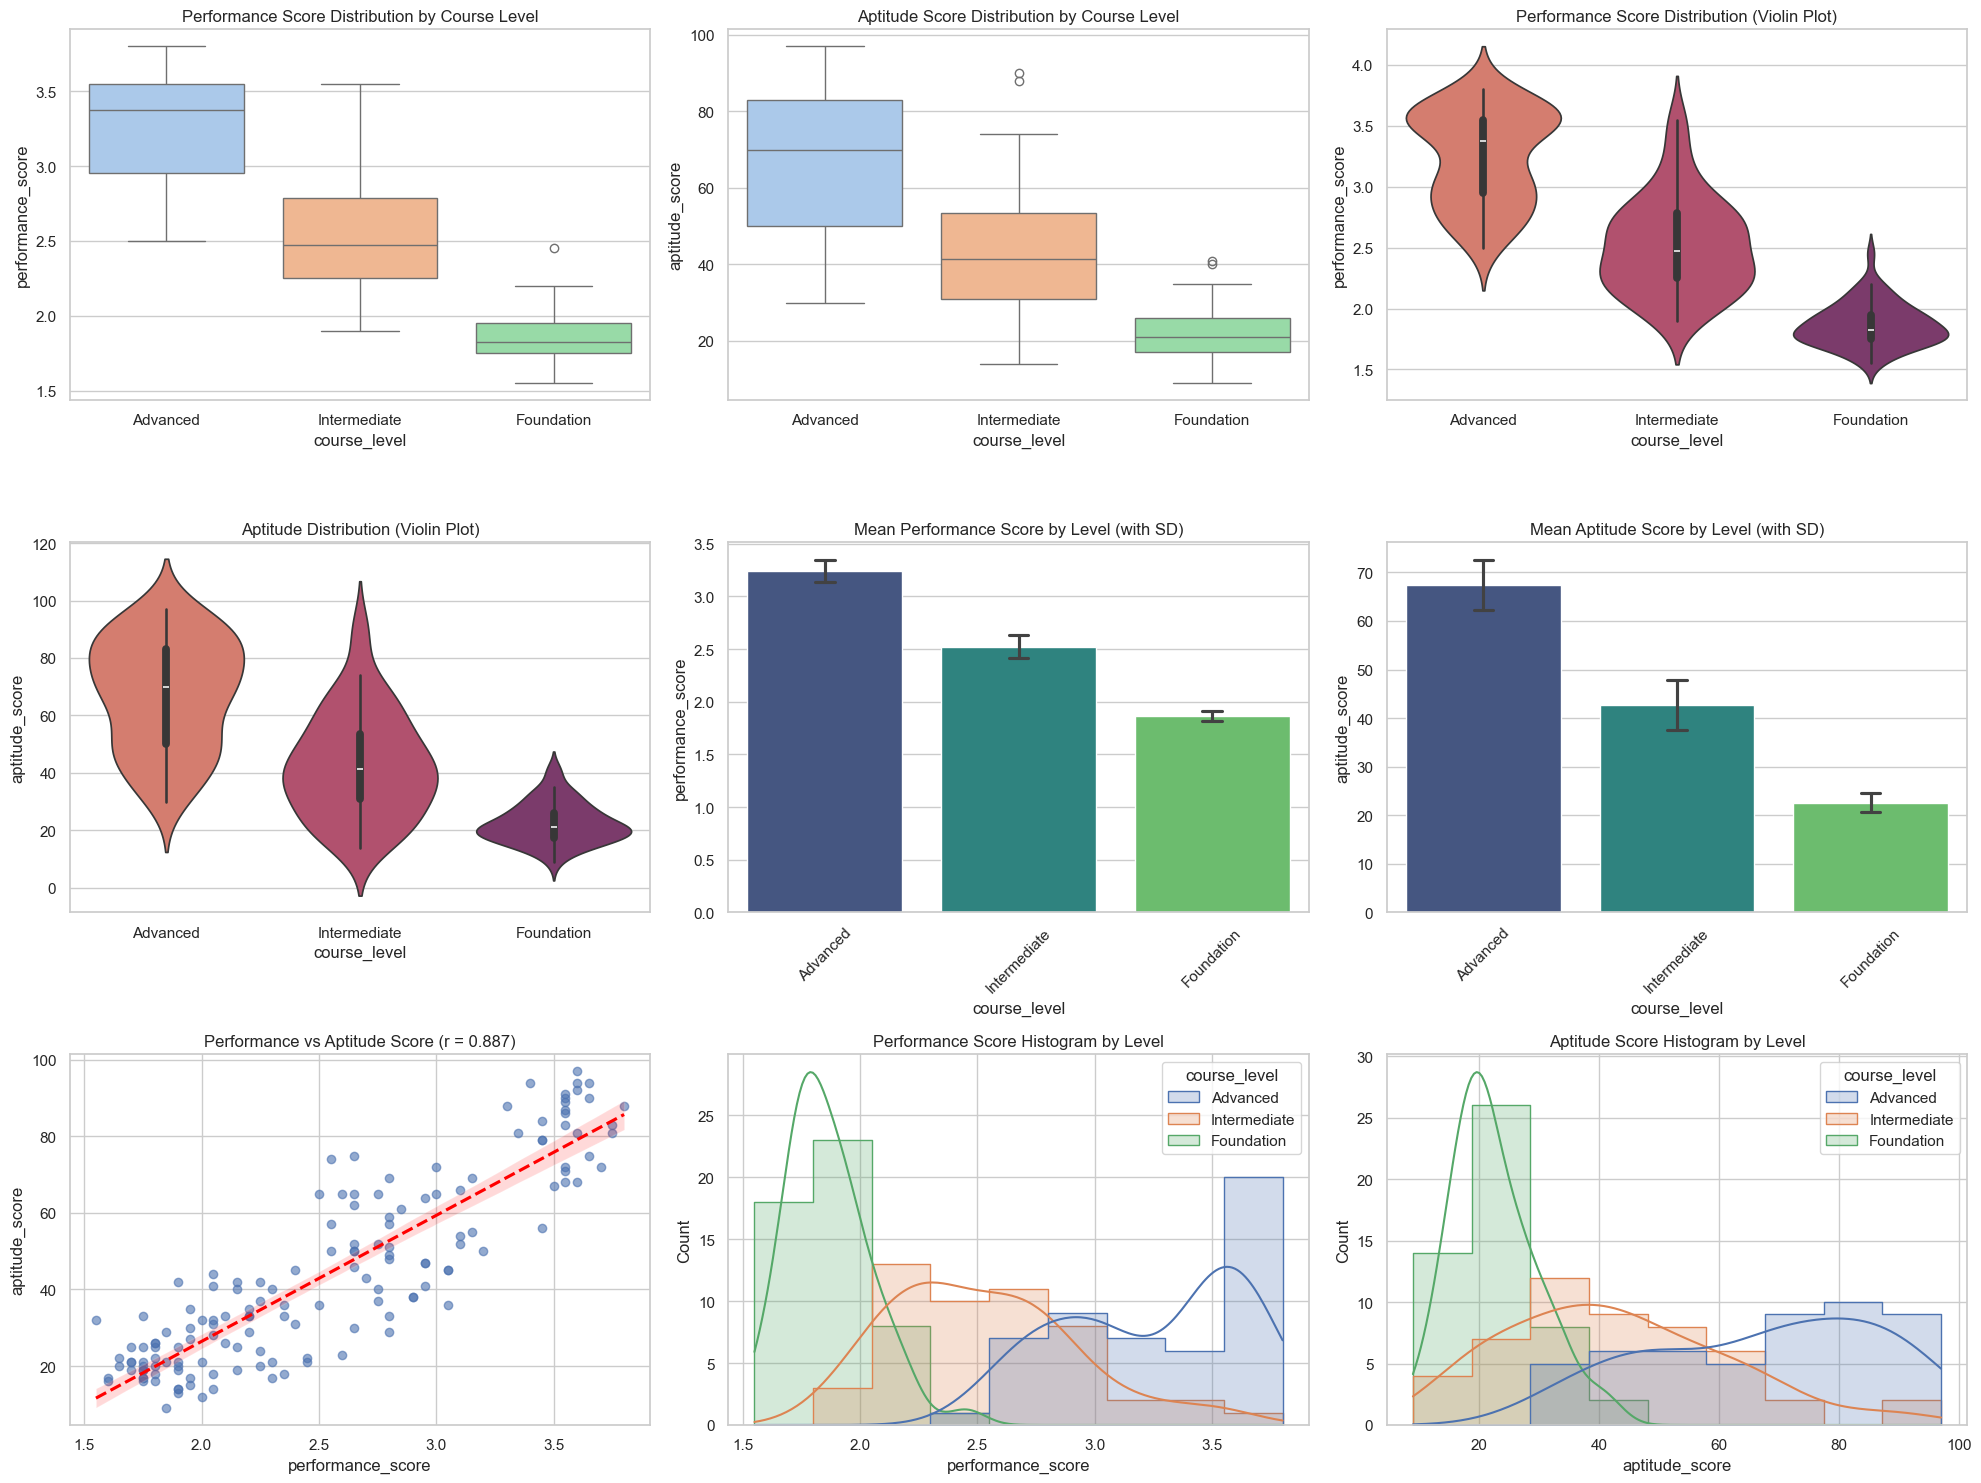

In [24]:
# Set tema visual agar terlihat profesional dan bersih
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- BARIS 1: DISTRIBUSI PERFORMANCE ---
# 1. Boxplot Performance
sns.boxplot(ax=axes[0, 0], x='course_level', y='performance_score', data=df_merged, palette='pastel')
axes[0, 0].set_title('Performance Score Distribution by Course Level')

# 2. Boxplot Aptitude
sns.boxplot(ax=axes[0, 1], x='course_level', y='aptitude_score', data=df_merged, palette='pastel')
axes[0, 1].set_title('Aptitude Score Distribution by Course Level')

# 3. Violin Plot Performance
sns.violinplot(ax=axes[0, 2], x='course_level', y='performance_score', data=df_merged, palette='flare')
axes[0, 2].set_title('Performance Score Distribution (Violin Plot)')


# --- BARIS 2: DISTRIBUSI APTITUDE & MEAN ---
# 4. Violin Plot Aptitude
sns.violinplot(ax=axes[1, 0], x='course_level', y='aptitude_score', data=df_merged, palette='flare')
axes[1, 0].set_title('Aptitude Distribution (Violin Plot)')

# 5. Bar Plot Mean Performance (dengan Error Bar/SD)
sns.barplot(ax=axes[1, 1], x='course_level', y='performance_score', data=df_merged, capsize=.1, palette='viridis')
axes[1, 1].set_title('Mean Performance Score by Level (with SD)')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Bar Plot Mean Aptitude (dengan Error Bar/SD)
sns.barplot(ax=axes[1, 2], x='course_level', y='aptitude_score', data=df_merged, capsize=.1, palette='viridis')
axes[1, 2].set_title('Mean Aptitude Score by Level (with SD)')
axes[1, 2].tick_params(axis='x', rotation=45)


# --- BARIS 3: KORELASI & HISTOGRAM ---
# 7. Scatter Plot (Aptitude vs Performance) - Perbaikan dari error sebelumnya
r_value = df_merged['aptitude_score'].corr(df_merged['performance_score'])
sns.regplot(ax=axes[2, 0], x='performance_score', y='aptitude_score', data=df_merged, 
            scatter_kws={'alpha':0.6}, line_kws={'color':'red', 'linestyle':'--'})
axes[2, 0].set_title(f'Performance vs Aptitude Score (r = {r_value:.3f})')

# 8. Histogram Performance Score
sns.histplot(ax=axes[2, 1], data=df_merged, x='performance_score', hue='course_level', kde=True, element="step")
axes[2, 1].set_title('Performance Score Histogram by Level')

# 9. Histogram Aptitude Score
sns.histplot(ax=axes[2, 2], data=df_merged, x='aptitude_score', hue='course_level', kde=True, element="step")
axes[2, 2].set_title('Aptitude Score Histogram by Level')

plt.tight_layout()
plt.show()

# Analysis of Student Performance and Aptitude Across Course Levels

## 1. Executive Summary
This report analyzes the relationship between course placement, student aptitude, and final performance. Despite minor violations of statistical normality and variance homogeneity, the results are highly robust due to the balanced sample size ($n=50$ per group). The findings confirm that the current leveling system is exceptionally effective in distinguishing student capabilities.

---

## 2. Research Question Findings

### RQ1: Do students with different performance levels enroll in different course levels?
**Findings: Yes.** There is a statistically significant difference in performance across all course levels.
* **Statistical Significance**: One-Way ANOVA results show $F = 213.43, p < 0.0001$.
* **Mean Performance**: Scores increase progressively from **Foundation (1.865)** to **Intermediate (2.518)** and **Advanced (3.239)**.
* **Post-hoc Validation**: Tukey HSD tests confirm that every pair of levels is significantly different from one another.

### RQ2: Are there significant differences in aptitude scores across course levels?
**Findings: Yes.** Aptitude scores vary significantly according to the assigned course level.
* **Statistical Significance**: ANOVA confirms significant variance ($F = 101.16, p < 0.0001$).
* **Confirmation**: Non-parametric Kruskal-Wallis tests yield identical conclusions ($p = 0.0000$), ensuring the result is not an error of distribution.
* **Gap Analysis**: The widest gap exists between **Advanced (Mean: 67.46)** and **Foundation (Mean: 22.52)**.

### RQ3: What is the correlation between aptitude scores and performance?
**Findings: There is a very strong, positive linear relationship.**
* **Correlation Coefficients**: 
    * **Pearson’s r**: **0.8874**.
    * **Spearman’s rho**: **0.8629**.
* **Interpretation**: Higher aptitude scores are extremely reliable predictors of higher final performance.

### RQ4: What are the implications for course placement and program quality?
* **Placement Effectiveness**: A massive **Cohen’s d of 4.59** for performance suggests that the placement criteria successfully separate students into distinct competency brackets.
* **Predictive Validity**: Because of the high correlation ($r = 0.887$), the initial aptitude test is a valid tool for forecasting student success